In [215]:
import numpy as np
import jax.numpy as jnp
import jax.random
from jax import grad,jit, vmap, pmap, value_and_grad
from matplotlib import pyplot as plt

In [35]:
rKEY = jax.random.PRNGKey(0)

This notebook is to habituate oneself with the syntax of jax in trying out a simple 2D classification problem. Two seperable datasets are generated and the goal is to classify them into two classes by minimising cross-entropy:
$$
\mathrm{argmax}\, \mathbb{E}_{\mathrm{x \sim data}} \left[ P(x) \log(Q(x))  + (1 - P(x))\log(1- Q(x))\right]
$$

Thereby $P(X)$ is the probability of data-point $x$ belonging to class "A" and $Q(x)$ is the variational distribution.

In [41]:
## Define Network components

@jit
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

@jit
def dense_layer(x, W, b):
    return sigmoid(jnp.matmul(W, x) + b)

In [248]:
# model parameters and store them in dictionary

W1 = jax.random.uniform(rKEY, shape = (20,2))
_, rKEY = jax.random.split(rKEY)
b1 = jax.random.uniform(rKEY, shape = (20,))
_, rKEY = jax.random.split(rKEY)
W2 = jax.random.uniform(rKEY, shape = (1,20))
_, rKEY = jax.random.split(rKEY)
b2 = jax.random.uniform(rKEY, shape = (1,))
_, rKEY = jax.random.split(rKEY)

params = {
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2
}


# training data
# e.g. intertwined rings

phi_A = jax.random.uniform(rKEY, shape = (500,))*2*jnp.pi
_, rKEY = jax.random.split(rKEY)
r_A = jax.random.uniform(rKEY, shape = (500,)) + 1.2
_, rKEY = jax.random.split(rKEY)
data_A = jnp.stack((jnp.cos(phi_A)*r_A, jnp.sin(phi_A)*r_A))


t = jax.random.categorical(rKEY, jnp.array([0., 0.]), shape = (500,))
_, rKEY = jax.random.split(rKEY)
phi_B = jax.random.uniform(rKEY, shape = (500,))*2*jnp.pi
_, rKEY = jax.random.split(rKEY)
r_B = jax.random.uniform(rKEY, shape = (500,))*0.8+0.3 + 2*t
_, rKEY = jax.random.split(rKEY)
data_B = jnp.stack((jnp.cos(phi_B)*r_B, jnp.sin(phi_B)*r_B))

In [272]:
# define Model and expand it to accept batches of data

model = lambda x, params: dense_layer(dense_layer(x, params["W1"], params["b1"]), params["W2"], params["b2"])[0]
batch_model = vmap(model, in_axes = (1, None))

In [273]:
# use the cross-entropy loss function defined above

@jit
def calc_loss(data_A, data_B, params):
    a = -jnp.mean(jnp.log(batch_model(data_A, params)))
    b = -jnp.mean(jnp.log(1 - batch_model(data_B, params)))
    return a + b 

In [274]:
# optimise loss

epoch = 0
N = 3000

# build auto-differentiator
act = value_and_grad(calc_loss, argnums = 2)

def apply_gradients(gradient_dict, l = 0.3):
    for key in params.keys():
        params[key] -= l*gradient_dict[key]

while epoch < N:
    epoch += 1
    loss, gradient_dict = act(data_A, data_B, params)
    apply_gradients(gradient_dict)


    if epoch % int(N / 20) == 0:
        print("loss:", loss)


loss: 0.12639779
loss: 0.124535695
loss: 0.12273956
loss: 0.121005565
loss: 0.11933019
loss: 0.117710166
loss: 0.11614244
loss: 0.114624165
loss: 0.11315262
loss: 0.111725375
loss: 0.11034
loss: 0.10899432
loss: 0.10768614
loss: 0.10641347
loss: 0.10517439
loss: 0.10396689
loss: 0.10278928
loss: 0.101639755
loss: 0.10051639
loss: 0.09941746


Text(0, 0.5, 'y')

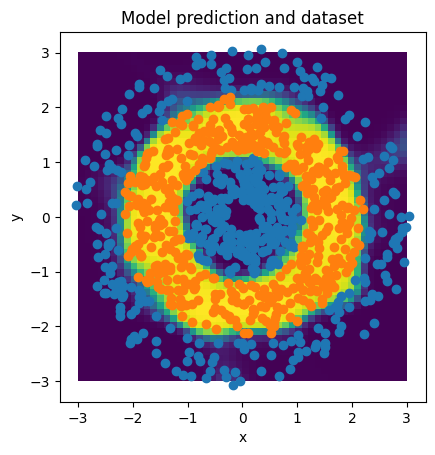

In [275]:
# visualise model predictions

xs, ys = jnp.meshgrid(jnp.linspace(-3, 3), jnp.linspace(-3, 3))
coords = jnp.stack((xs, ys)).reshape(2, -1)
img = batch_model(coords, params).reshape((50, 50))
plt.imshow(img, extent = [-3,3, -3, 3])
plt.scatter(data_B[0, :], data_B[1, :])
plt.scatter(data_A[0, :], data_A[1, :])

plt.title("Model prediction and dataset")
plt.xlabel("x")
plt.ylabel("y")

In [301]:
# do some autodiff-fun (differentiate the above picture wrt. x and y)

dat = vmap(grad(model, argnums = 0), in_axes=(1, None))(coords, params)
img_x = dat[:, 0].reshape(50,50)
img_y = dat[:, 1].reshape(50,50)

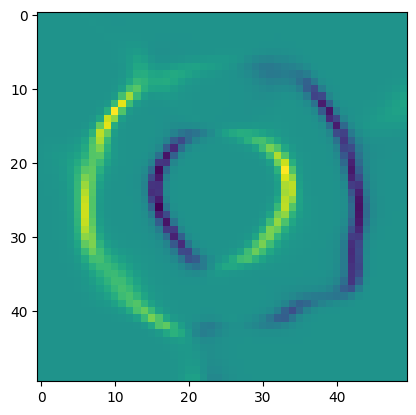

In [300]:
plt.imshow(img_x)